In [18]:
using Pkg
Pkg.activate("BosonStars")
using Revise
using Skylight
using StatsBase
using CairoMakie
using LinearAlgebra
using Printf
using Colors
using DataFrames
using GLM
using DelimitedFiles
includet("corona.jl")
includet("ranges.jl")
includet("juliacolors.jl")

  Activating project at `~/BosonStars/BosonStars`


Boson star

In [4]:
modelname = "SBS"
modelid = 3
filenames = get_filenames(modelname)
obs_configurations = load_configurations_from_hdf5("io/$(filenames[modelid,1]).h5")
spacetime = obs_configurations.spacetime
disk = obs_configurations.radiative_model

AccretionDiskWithTabulatedTemperature{ProgradeRotation, DataInterpolations.LinearInterpolation{Vector{Float64}, Vector{Float64}, true, Float64}}
  inner_radius: Float64 6.8
  outer_radius: Float64 79.8
  rotation_sense: ProgradeRotation ProgradeRotation()
  filename: String "tables/TempSBS3.dat"
  temperature_interpolator: DataInterpolations.LinearInterpolation{Vector{Float64}, Vector{Float64}, true, Float64}


In [6]:
corona = LamppostCorona(height=10.0, theta_offset=1e-5, spectral_index = 2.0)
configurations = VacuumETOConfigurations(spacetime=spacetime,
                                   radiative_model = corona,
                                   number_of_points=1,
                                   number_of_packets_per_point = 1000000, 
                                   max_radius = 110.0,
                                   unit_mass_in_solar_masses=1.0)
initial_data = initialize(configurations)
cbp = callback_parameters(spacetime, disk, configurations)
cb = callback(spacetime, disk)
sim = integrate(initial_data, configurations, cb, cbp; method=VCABM(), reltol=1e-5, abstol=1e-5)
output_data = sim.output_data
at_source = map(position -> is_final_position_at_source(position, spacetime, disk) && position[3] ≈ π/2, eachcol(output_data))
radii = output_data[2,at_source]
q = energies_quotients(output_data[:,at_source], spacetime, disk)


┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=9.529924133117953, and step error estimate = 1.0. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=9.558641890740876, and step error estimate = 1.245084453258875. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=0.00024271876623032916, and step error estimate = 1.0731246464318462. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: dt(2.32830643

┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=10.878283184855784, and step error estimate = 1.618184507237707. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=9.88266925808946, and step error estimate = 0.6975184849302537. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:606
┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=10.533924747737064, and step error estimate = 0.8450933146296782. Aborting. There is either an error in your model specification or th

┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=9.59668390950537, and step error estimate = 0.7449208761330055. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=11.38426076522808, and step error estimate = 1.379730771241342. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=11.237833571377056, and step error estimate = NaN. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: dt(2.3283064365386

┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=0.00010143407577185795, and step error estimate = 0.9622173655985143. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=10.067956399580819, and step error estimate = 1.0. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:606
┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=10.295068136673185, and step error estimate = 1.1543275921021519. Aborting. There is either an error in your model specification or the true s

┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=11.43295936538838, and step error estimate = 1.5167126291198418. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599


┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=9.982863909713917, and step error estimate = 0.983891590531476. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:580


Equations integration stats:
Wall clock time: 54.367386758 seconds
Memory allocated: 136.080 GiB


CompositeException: TaskFailedException

    nested task error: UndefVarError: `emitter_four_velocity!` not defined
    Stacktrace:
     [1] macro expansion
       @ ~/BosonStars/corona.jl:56 [inlined]
     [2] (::var"#20#22"{UnitRange{Int64}, Matrix{Float64}, BosonStarSpacetime, AccretionDiskWithTabulatedTemperature{ProgradeRotation, DataInterpolations.LinearInterpolation{Vector{Float64}, Vector{Float64}, true, Float64}}, Vector{Float64}, SphericalTopology})()
       @ Main ./threadingconstructs.jl:404

...and 112 more exceptions.


In [14]:
# bins = radial_bins(disk, nbins=100)
bins = range(cbrt(disk.inner_radius), stop=cbrt(disk.outer_radius), length=50).^3
A = ring_areas(bins, spacetime)
γ = lorentz_factors(bins, spacetime, disk)
h = fit(Histogram, radii, bins)
h = normalize(h, mode=:probability)
𝓝 = h.weights

qavg = average_inside_radial_bins(q, radii, bins)

Γ = corona.spectral_index
n = 𝓝./(A.*γ)
I = qavg.^Γ.*n

bins_midpoints = 0.5*(bins[1:end-1] + bins[2:end])
nothing

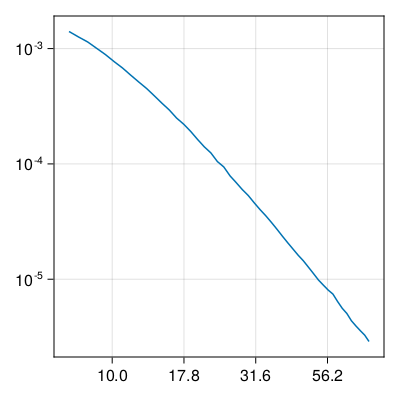

In [61]:
hstr = string(@sprintf("%02d", corona.height))
istr = string(@sprintf("%02d", corona.spectral_index))
filename = "io/corona/bosonstar/$(modelname)$(modelid)_h$(hstr)_idx$(istr).txt"
open(filename, "w") do io
    writedlm(io, [bins_midpoints I])
end


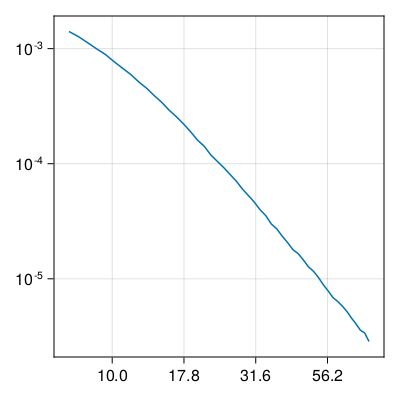

In [15]:

fig = Figure(resolution=(400,400))
ax = Axis(fig[1,1])
lines!(ax, bins_midpoints, I)
ax.xscale = log10
ax.yscale = log10
# xlims!(1.0,200)
# ylims!(1e-6, 1e0)
ax.xtickformat = "{:.1f}"
fig

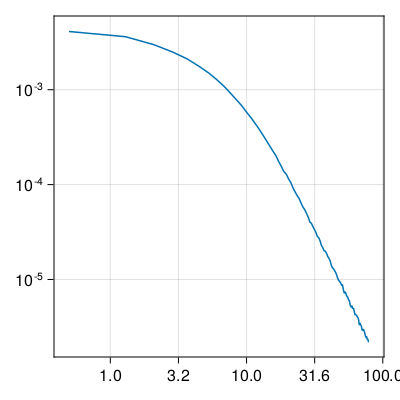

In [ ]:
hstr = string(@sprintf("%02d", corona.height))
istr = string(@sprintf("%02d", corona.spectral_index))
filename = "io/corona/bosonstar/$(modelname)$(modelid)_h$(hstr)_idx$(istr).txt"
open(filename, "w") do io
    writedlm(io, [bins_midpoints I])
end

fig = Figure(resolution=(400,400))
ax = Axis(fig[1,1])
lines!(ax, bins_midpoints, I)
ax.xscale = log10
ax.yscale = log10
# xlims!(1.0,200)
# ylims!(1e-6, 1e0)
ax.xtickformat = "{:.1f}"
fig

In [43]:
bins_midpoints[40]

31.5025

In [62]:
imin = 25
df = DataFrame(logr = log10.(bins_midpoints[imin:end]), logI = log10.(I[imin:end]))
ols = lm(@formula(logI ~ logr), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

logI ~ 1 + logr

Coefficients:
───────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error        t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)   0.155585   0.0211157     7.37    <1e-06   0.111903   0.199266
logr         -3.00162    0.0124221  -241.64    <1e-39  -3.02732   -2.97592
───────────────────────────────────────────────────────────────────────────

Kerr black hole

┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=0.00011984470121781236, and step error estimate = 2.791249774119194. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=0.00010804074891251015, and step error estimate = 2.793672084003822. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=0.00012394410918342014, and step error estimate = 1.3251364362449116. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599


┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=0.00010298403210486574, and step error estimate = 1.0099365361610029. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599


Equations integration stats:
Wall clock time: 77.850827239 seconds
Memory allocated: 322.855 GiB


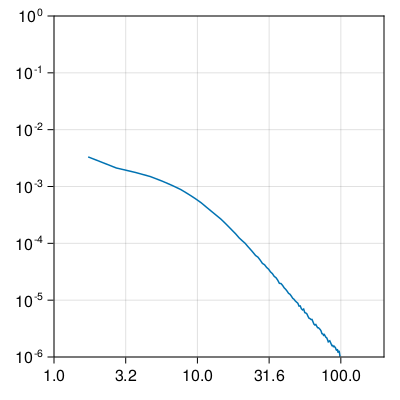

In [19]:
spacetime = KerrSpacetimeBoyerLindquistCoordinates(M=1.0,a=0.998)
corona = LamppostCorona(height=10.0, theta_offset=1e-5, spectral_index = 2.0)
configurations = VacuumETOConfigurations(spacetime=spacetime,
                                   radiative_model = corona,
                                   number_of_points=1,
                                   number_of_packets_per_point = 1000000, 
                                   max_radius = 110.0,
                                   unit_mass_in_solar_masses=1.0)
initial_data = initialize(configurations)
disk = NovikovThorneDisk(inner_radius = isco_radius(spacetime, ProgradeRotation()), outer_radius = 100.0)
cbp = callback_parameters(spacetime, disk, configurations; rhorizon_bound=2e-3)
cb = callback(spacetime, disk)
sim = integrate(initial_data, configurations, cb, cbp; method=VCABM(), reltol=1e-5, abstol=1e-5)
output_data = sim.output_data
at_source = map(position -> is_final_position_at_source(position, spacetime, disk) && position[3] ≈ π/2, eachcol(output_data))
radii = output_data[2,at_source]
q = energies_quotients(output_data[:,at_source], spacetime, disk)
bins = radial_bins(disk, nbins=100)
# bins = r_in*exp10.(range(0.0, stop=log10(r_out/r_in), length=100))
A = ring_areas(bins, spacetime)
γ = lorentz_factors(bins, spacetime, disk)
h = fit(Histogram, radii, bins)
h = normalize(h, mode=:probability)
𝓝 = h.weights

qavg = average_inside_radial_bins(q, radii, bins)

Γ = corona.spectral_index
n = 𝓝./(A.*γ)
I = qavg.^Γ.*n

bins_midpoints = 0.5*(bins[1:end-1] + bins[2:end])

astr = string(@sprintf("%02d", spacetime.a))
hstr = string(@sprintf("%02d", corona.height))
istr = string(@sprintf("%02d", corona.spectral_index))
filename = "io/corona/kerr/a$(astr)_h$(hstr)_idx$(istr).txt"
open(filename, "w") do io
    writedlm(io, [bins_midpoints I])
end

fig = Figure(resolution=(400,400))
ax = Axis(fig[1,1])
lines!(ax, bins_midpoints, I)
ax.xscale = log10
ax.yscale = log10
xlims!(1.0,200)
ylims!(1e-6, 1e0)
ax.xtickformat = "{:.1f}"
fig

In [15]:
df = DataFrame(logr = log10.(bins_midpoints[16:end]), logI = log10.(I[16:end]))
ols = lm(@formula(logI ~ logr), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

logI ~ 1 + logr

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error        t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)   0.020696  0.0154046      1.34    0.1883  -0.0106449   0.0520368
logr         -2.99434   0.00856143  -349.75    <1e-59  -3.01175    -2.97692
─────────────────────────────────────────────────────────────────────────────